This notebook explores the graph segmentation stage and evaluate the performance of the track candidates.

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

In [1]:
from acctrack.io.pyg_data_reader import TrackGraphDataReader
from acctrack.io.reco_trkx import RecoTrkxReader
import numpy as np
import pandas as pd
import acctrack.tools.tracks_from_gnn as track_builder
import acctrack.tools.evaluate_reco_tracks as track_eval
from matplotlib import pyplot as plt

uproot is not installed. AthenaRawRootReader will not be available.


In [2]:
def get_matching_df(
    reconstruction_df, particles_df, min_track_length=1, min_particle_length=1
):
    # Get track lengths
    candidate_lengths = (
        reconstruction_df.track_id.value_counts(sort=False)
        .reset_index()
        .rename(columns={"index": "track_id", "track_id": "n_reco_hits"})
    )

    # Get true track lengths
    particle_lengths = (
        reconstruction_df.drop_duplicates(subset=["hit_id"])
        .particle_id.value_counts(sort=False)
        .reset_index()
        .rename(columns={"index": "particle_id", "particle_id": "n_true_hits"})
    )

    spacepoint_matching = (
        reconstruction_df.groupby(["track_id", "particle_id"])
        .size()
        .reset_index()
        .rename(columns={0: "n_shared"})
    )

    spacepoint_matching = spacepoint_matching.merge(
        candidate_lengths, on=["track_id"], how="left"
    )
    spacepoint_matching = spacepoint_matching.merge(
        particle_lengths, on=["particle_id"], how="left"
    )
    spacepoint_matching = spacepoint_matching.merge(
        particles_df, on=["particle_id"], how="left"
    )

    # Filter out tracks with too few shared spacepoints
    spacepoint_matching["is_matchable"] = (
        spacepoint_matching.n_reco_hits >= min_track_length
    )
    spacepoint_matching["is_reconstructable"] = (
        spacepoint_matching.n_true_hits >= min_particle_length
    )

    return spacepoint_matching

def calculate_matching_fraction(spacepoint_matching_df):
    spacepoint_matching_df = spacepoint_matching_df.assign(
        purity_reco=np.true_divide(
            spacepoint_matching_df.n_shared, spacepoint_matching_df.n_reco_hits
        )
    )
    spacepoint_matching_df = spacepoint_matching_df.assign(
        eff_true=np.true_divide(
            spacepoint_matching_df.n_shared, spacepoint_matching_df.n_true_hits
        )
    )

    return spacepoint_matching_df


In [4]:
evtid = 5020
tf_infer_filename = "/pscratch/sd/x/xju/ITk/ForFinalPaper/gnn4itk/tfgraphs/gnn_val/5020.npz"
torch_data_filename = "/global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/metric_learning_testing/trainset"
outdir = "/pscratch/sd/x/xju/ITk/ForFinalPaper/gnn4itk/tfgraphs/track_candidates"


Build track candidates

In [5]:
track_builder.process(tf_infer_filename, torch_data_filename, outdir, score_name="score")

/global/homes/x/xju/.conda/envs/gnn4itk/lib/python3.9/site-packages/sklearn/neighbors/_base.py:234: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(


Evaluate the track candidates

In [6]:
reader = TrackGraphDataReader(torch_data_filename, name="GNN")
data = reader.read(0)

df_particles = pd.DataFrame({"particle_id": data.particle_id, "pt": data.pt})
print(df_particles.shape)
df_particles = df_particles.drop_duplicates(subset=["particle_id"])
print("after duplicate removal", df_particles.shape)

# read reco tracks
hit_id = data.hit_id
reco_reader = RecoTrkxReader(outdir)
submission = reco_reader(evtid)

track_id = np.zeros(hit_id.shape[0], dtype=np.int64)
track_id[submission.hit_id] = submission.track_id

pids = np.zeros(hit_id.shape[0], dtype=np.int64)
pids[data.track_edges[0]] = data.particle_id
pids[data.track_edges[1]] = data.particle_id
df_reco = pd.DataFrame({"hit_id": hit_id, "track_id": track_id, "particle_id": pids})

GNN: Total 3 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/metric_learning_testing/trainset
Reading file: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/metric_learning_testing/trainset/event000005020.pyg
(103066, 2)
after duplicate removal (12212, 2)


In [8]:
min_track_length = min_particle_length = 1
matching_df = get_matching_df(
    df_reco,
    df_particles,
    min_track_length=min_track_length,
    min_particle_length=min_particle_length,
)
matching_df["event_id"] = int(evtid)

In [9]:
matching_df = calculate_matching_fraction(matching_df)
matching_fraction = 0.5
matching_df["is_matched"] = matching_df["is_reconstructed"] = (
    matching_df.purity_reco >= matching_fraction
)

In [10]:
matching_df

,track_id,particle_id,n_shared,n_reco_hits,n_true_hits,pt,is_matchable,is_reconstructable,event_id,purity_reco,eff_true,is_matched,is_reconstructed
0,-1,0,126505,179699,149834,NaN,True,True,5020,0.703983,0.844301,True,True
1,-1,969,5,179699,9,80375.300,True,True,5020,0.000028,0.555556,False,False
2,-1,1032,10,179699,11,1526.980,True,True,5020,0.000056,0.909091,False,False
3,-1,1034,4,179699,9,550.850,True,True,5020,0.000022,0.444444,False,False
4,-1,1037,5,179699,10,2130.540,True,True,5020,0.000028,0.500000,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26389,11674,0,2,2,149834,NaN,True,True,5020,1.000000,0.000013,True,True
26390,11675,4490000200014,2,2,6,383.097,True,True,5020,1.000000,0.333333,True,True
26391,11676,5410000001382,2,2,18,672.286,True,True,5020,1.000000,0.111111,True,True
26392,11677,4560000000163,2,2,13,903.599,True,True,5020,1.000000,0.153846,True,True


In [11]:
matching_df[matching_df.particle_id != 0]

,track_id,particle_id,n_shared,n_reco_hits,n_true_hits,pt,is_matchable,is_reconstructable,event_id,purity_reco,eff_true,is_matched,is_reconstructed
1,-1,969,5,179699,9,80375.300,True,True,5020,0.000028,0.555556,False,False
2,-1,1032,10,179699,11,1526.980,True,True,5020,0.000056,0.909091,False,False
3,-1,1034,4,179699,9,550.850,True,True,5020,0.000022,0.444444,False,False
4,-1,1037,5,179699,10,2130.540,True,True,5020,0.000028,0.500000,False,False
5,-1,1041,5,179699,10,8669.540,True,True,5020,0.000028,0.500000,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26388,11673,5050000000215,1,2,16,738.970,True,True,5020,0.500000,0.062500,True,True
26390,11675,4490000200014,2,2,6,383.097,True,True,5020,1.000000,0.333333,True,True
26391,11676,5410000001382,2,2,18,672.286,True,True,5020,1.000000,0.111111,True,True
26392,11677,4560000000163,2,2,13,903.599,True,True,5020,1.000000,0.153846,True,True


In [25]:
uids, counts = np.unique(matching_df.particle_id, return_counts=True)

In [26]:
uids[counts > 1]

array([            0,           969,          1032, ..., 6050000200052,
       6050000200275, 6050000200281])

In [27]:
matching_df[matching_df.particle_id == 969]

,track_id,particle_id,n_shared,n_reco_hits,n_true_hits,pt,is_matchable,is_reconstructable,event_id,purity_reco,eff_true,is_matched,is_reconstructed
1,-1,969,5,179699,9,80375.3,True,True,5020,0.000028,0.555556,False,False
20228,6371,969,4,4,9,80375.3,True,True,5020,1.000000,0.444444,True,True


In [28]:
matching_df[matching_df.track_id == 6371]

,track_id,particle_id,n_shared,n_reco_hits,n_true_hits,pt,is_matchable,is_reconstructable,event_id,purity_reco,eff_true,is_matched,is_reconstructed
20228,6371,969,4,4,9,80375.3,True,True,5020,1.0,0.444444,True,True


In [29]:
submission[submission.track_id == 6371]

,track_id,hit_id
89988,6371,97862
96227,6371,104630
101575,6371,110575
101689,6371,110705


Text(0.5, 0, 'n_shared')

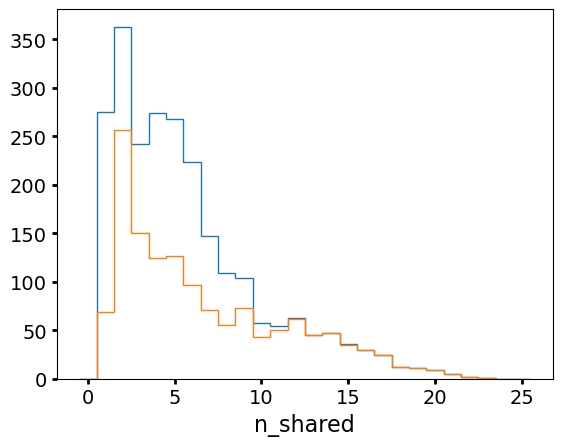

In [18]:
pid_cuts = (matching_df.particle_id != 0) & (matching_df.pt > 1000) & (matching_df.n_true_hits > 5)
matching_cuts = pid_cuts & (matching_df.is_matched == True)
plt.hist(matching_df[pid_cuts].n_shared, bins=26, range=(-0.5, 25.5), histtype="step", label="all")
plt.hist(matching_df[matching_cuts].n_shared, bins=26, range=(-0.5, 25.5), histtype="step", label="matched")
plt.xlabel("n_shared")

In [20]:
df_particles[(df_particles.particle_id != 0) & (df_particles.pt > 1000)]

,particle_id,pt
13,5900000000667,1009.37
17,5410000001296,1037.30
27,5910000000532,1484.17
36,5410000001436,1789.80
58,5560000000954,1943.98
...,...,...
100543,4830000200225,1092.23
101008,5900000200228,1018.58
101131,4830000200515,1345.33
101579,5260000200281,2170.67


In [21]:
particles = matching_df[(matching_df.particle_id != 0) & (matching_df.is_reconstructable == True)]

In [22]:
particles

,track_id,particle_id,n_shared,n_reco_hits,n_true_hits,pt,is_matchable,is_reconstructable,event_id,purity_reco,eff_true,is_matched,is_reconstructed
1,-1,969,5,179699,9,80375.300,True,True,5020,0.000028,0.555556,False,False
2,-1,1032,10,179699,11,1526.980,True,True,5020,0.000056,0.909091,False,False
3,-1,1034,4,179699,9,550.850,True,True,5020,0.000022,0.444444,False,False
4,-1,1037,5,179699,10,2130.540,True,True,5020,0.000028,0.500000,False,False
5,-1,1041,5,179699,10,8669.540,True,True,5020,0.000028,0.500000,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26388,11673,5050000000215,1,2,16,738.970,True,True,5020,0.500000,0.062500,True,True
26390,11675,4490000200014,2,2,6,383.097,True,True,5020,1.000000,0.333333,True,True
26391,11676,5410000001382,2,2,18,672.286,True,True,5020,1.000000,0.111111,True,True
26392,11677,4560000000163,2,2,13,903.599,True,True,5020,1.000000,0.153846,True,True


In [23]:
df_particles.shape

(12212, 2)